In [4]:
import matplotlib.pyplot as plt
from qutip import *
import numpy as np
import pickle, os
import copy

# Import the outsourced settings / functions
from plot_settings import *
from functions2DES import *

Plot not saved. Ensure 'safe' is True and 'output_dir' is specified.


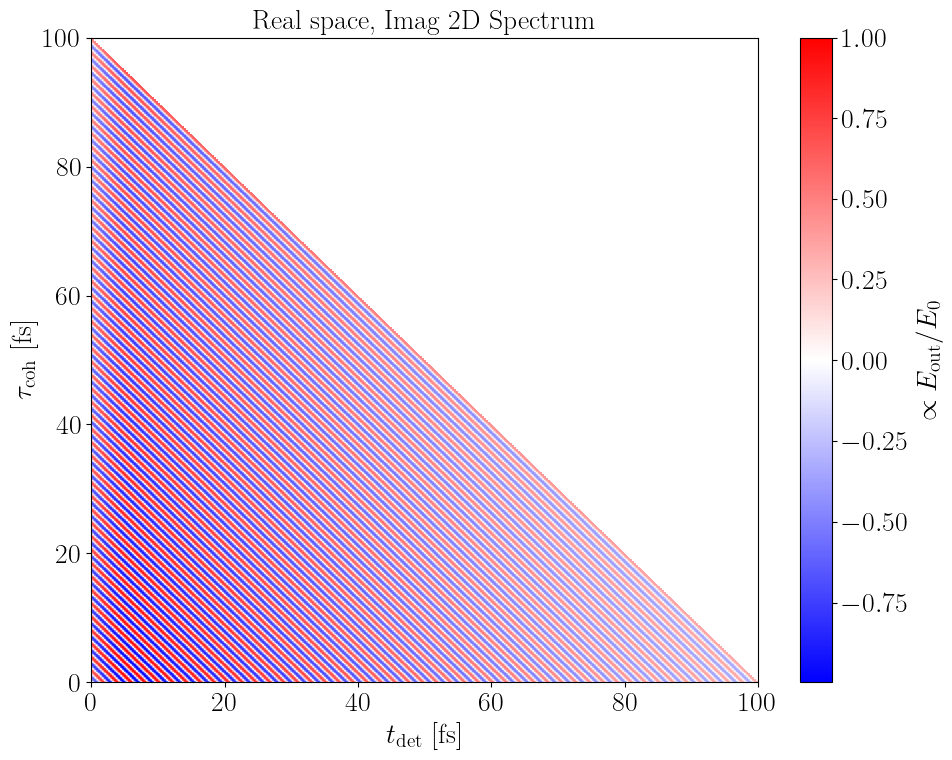

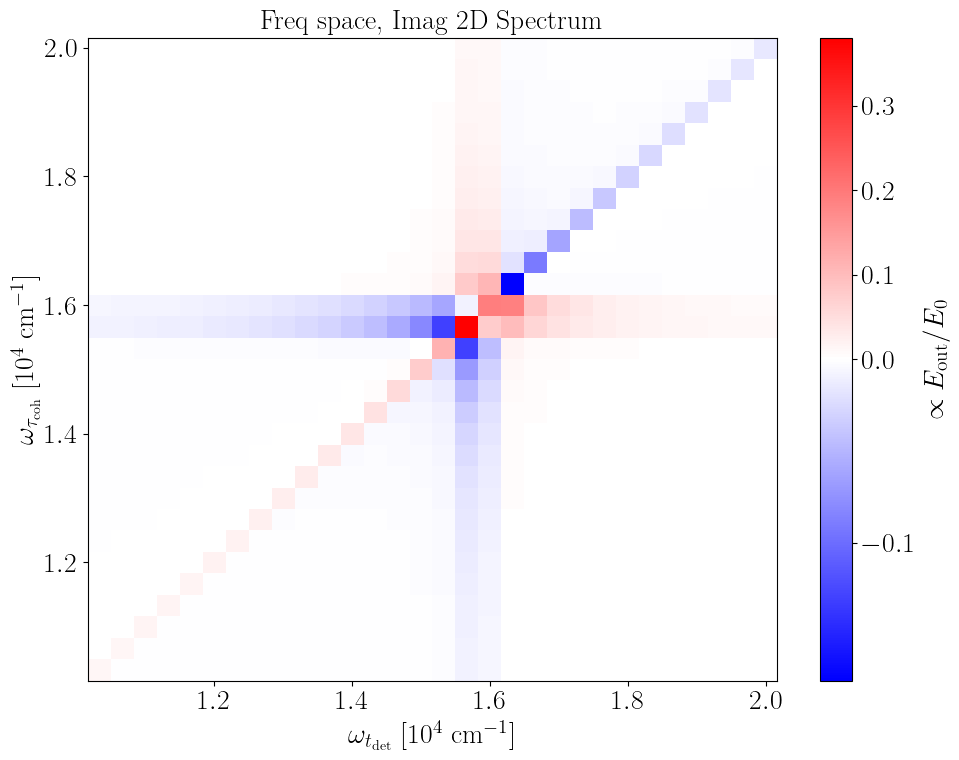

In [10]:
# =============================
# Load 2D data from pickle file
# =============================
script_dir = os.getcwd()
filename = "data_tmax_100_dt_0.1.pkl"
save_path = os.path.join(script_dir, "papers_with_proteus_output", filename)

with open(save_path, "rb") as f:
    data = pickle.load(f)
    system_data = data["system"]
    times = data["times"]
    times_T = data["times_T"]
    two_d_datas = data["two_d_datas"]
#print("Loaded simulation with parameters", system_data.summary())

# =============================
# Plotting arguments
# =============================
plot_args_freq = dict(
    space="freq",
    type="imag",  # plot the real part (also "imag", "phase", "abs")
    safe=True,  # (dont) save the spectrum
    output_dir=script_dir + "/figures",  # where to save the spectrum
    positive=True,  # only plot the positive spectrum
    use_custom_colormap=True,  # all zeros are white
    # section=(1.53, 1.65, 1.53, 1.65),  # focus on the non zero feature
    section=(1., 2., 1., 2.),  # focus on the non zero feature
    system=system_data,
)

# =============================
# plot for many T_waits
# =============================
extend_for = (0, 1)  # make the plot smooth

extend_and_plot_results(
    two_d_datas,
    times_T=times_T,
    times=times,
    extend_for=extend_for,
    **plot_args_freq,
)

In [ ]:
# Import the outsourced settings / functions
from functions2DES import *

import numpy as np
import psutil  # -> estimate RAM usage
import copy  # -> copy classes
import time  # -> estimate elapsed time

import pickle  # -> safe data
import sys  # safe data
import os  # -> safe data


### Phase Cycling for Averaging
phases = [k * np.pi / 2 for k in range(4)]


def main():
    """
    Main function to run the script.
    """
    start_time = time.time()  # Start timing

    # =============================
    # SYSTEM PARAMETERS
    # =============================
    system = SystemParameters(
        # WHICH SYSTEM:
        N_atoms=1,
        ODE_Solver="Paper_eqs",
        RWA_laser=True,
        # SIMULATION:
        t_max=20.0,  # -> determines Δω
        dt=0.1,  # -> determines ω_max
        # NECESSARY FOR THE DELAYED PHOTON EFFECT:
        Delta_cm=200,  # -> determines Δω
    )

    system.summary()

    t_max = system.t_max
    dt_test = system.dt

    Delta_ts = system.Delta_ts
    times = np.arange(-Delta_ts[0], t_max, dt_test)
    # print("times: ", times[0], times[1], "...", times[-1], "len", len(times))

    # =============================
    test_params_copy = copy.deepcopy(system)
    # =============================
    # ALWAYS CHECK Before running a serious simulation
    # =============================
    test_params_copy.t_max = 10 * t_max
    test_params_copy.dt = 10 * dt_test
    times_test_ = np.arange(
        -Delta_ts[0], test_params_copy.t_max, test_params_copy.dt
    )
    _, time_cut = check_the_solver(times_test_, test_params_copy)
    print("\nthe evolution is actually unphysical after:", time_cut, "fs")

    T_wait = times[-1] / 100
    times_T = [T_wait]
    N_sample = 10  # the bigger the better
    omega_ats = sample_from_sigma(N_sample, system.Delta, system.omega_A, E_range=3)
    kwargs = {"plot_example": False}

    # DO THE SIMULATION
    if system.Delta == 0:
        two_d_datas = parallel_process_all_combinations(
            phases=phases,
            times_T=times_T,
            times=times,
            system=system,
            kwargs=kwargs,
        )
    else:
        two_d_datas = parallel_process_all_combinations_with_inhomogenity(
            omega_ats=omega_ats,
            phases=phases,
            times_T=times_T,
            times=times,
            system=system,
            kwargs=kwargs,
        )

    # =============================
    # Set output directory to a subfolder named 'output'
    # =============================

    if len(sys.argv) > 1:
        output_dir = sys.argv[1]
    else:
        output_dir = os.path.join(os.path.dirname(os.path.abspath(__file__)), "output")

    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists

    # Construct base filename for saving
    base_filename = f"data_tmax{system.t_max:.0f}_dt_{system.dt}.pkl"
    save_path = os.path.join(output_dir, base_filename)

    counter = 1
    while os.path.exists(save_path):
        save_path = os.path.join(
            output_dir,
            f"data_tmax{system.t_max:.0f}_dt_{system.dt}_{counter}.pkl",
        )
        counter += 1

    with open(save_path, "wb") as f:
        pickle.dump(
            {
                "system": system,
                "times": times,  # maybe not needed
                "times_T": times_T,
                "two_d_datas": two_d_datas,
            },
            f,
        )
        print(
            f"\n2D system info, times_T, times and the spectral data was saved to {save_path}"
        )

    # =============================
    # Print elapsed time and memory usage for performance monitoring
    # =============================
    elapsed_time = time.time() - start_time
    hours = int(elapsed_time // 3600)
    minutes = int((elapsed_time % 3600) // 60)
    seconds = elapsed_time % 60
    print(f"\nExecution time: {hours}h {minutes}m {seconds:.2f}s")

    process = psutil.Process(os.getpid())
    mem_bytes = process.memory_info().rss  # Resident Set Size: memory in bytes
    mem_mb = mem_bytes / (1024**2)  # Convert to MB
    numbytes = 8  # 8 bytes per complex number
    bound_mem_my_estimate = (
        2 * len(times_T) * len(phases) ** 2 * len(times) ** 2 * N_sample * numbytes / (1024**2)
    )  # 8 bytes per complex number
    print(
        f"\nApproximate memory usage: {mem_mb:.2f} MB vs my estimate: {bound_mem_my_estimate:.2f} MB"
    )


if __name__ == "__main__":
    main()


In [ ]:
test_params_copy         = copy.deepcopy(test_params)
if 'time_cut' not in globals() or test_params_copy.t_max != test_params.t_max:
    # =============================
    # ALWAYS CHECK Before running a serious simulation
    # =============================
    test_params_copy.t_max   = 10 * t_max_test
    test_params_copy.dt = 10 * dt_test
    times_test_              = np.arange(-test_Delta_ts[0], test_params_copy.t_max, test_params_copy.dt)
    result, time_cut         = check_the_solver(times_test_, test_params_copy)
    print("the evolution is actually unphisical after:", time_cut, "fs")

In [ ]:
T_wait_test = 1* (times_test_[1]- times_test_[0])
data_test_0 = compute_two_dimensional_polarization(T_wait_test, phases[0], phases[0], times=times_test, system=test_params,   plot_example=True)
#data_test_1 = compute_many_polarizations(T_wait_test, phases[0], phases[0], times=times_test_, N=10, E0=omega_A, Delta=Delta)

In [ ]:
plot_args_freq = dict(                   # (**changeable**) 
    space="freq",                   
    type="real",                    # plot the real part (also "imag", "phase", "abs")
    safe=False,                     # (dont) save the spectrum
    positive=True,                  # only plot the positive spectrum
    use_custom_colormap=True,# all zeros are white
    section=(1.525, 1.675, 1.525, 1.675),  # focus on the non zero feature


    # add more options as needed
)

ts, taus, data = data_test_0[0], data_test_0[1], data_test_0[2]
#ts, taus, data, omega_samples = data_test_1[0], data_test_1[1], data_test_1[2], data_test_1[3]

extend_for = (0, 0)
ts, taus, data = extend_time_tau_axes(ts, taus, data, pad_rows=extend_for, pad_cols=extend_for)
plot_positive_color_map(
    (ts, taus, data),
    type="imag", # because E ~ i*P
    T_wait=T_wait_test, 
    safe=False,
    use_custom_colormap=True,
)

nu_ts, nu_taus, s2d = compute_2d_fft_wavenumber(ts, taus, data)
plot_positive_color_map(
    (nu_ts, nu_taus, s2d),
    T_wait=T_wait_test, 
    **plot_args_freq
)

In [ ]:
# =============================
# THIS CELL IS MAINLY FOR TESTING
# =============================
# Example input data
"""
ts    = np.array([0.0, 1.0, 2.0])
taus  = np.array([0.0, 1.0, 2.0, 3.0])
data  = np.arange(12).reshape(4, 3)  # shape (4, 3)

# Pad 1 row before, 2 rows after; 1 col before, 1 col after
pad_rows = (0, 0)
pad_cols = (1, 1)

extended_ts, extended_taus, padded_data = extend_time_tau_axes(
    ts, taus, data, pad_rows=pad_rows, pad_cols=pad_cols
)

print("Original data shape:", data.shape)
print("Padded data shape:", padded_data.shape)
print("Extended ts:", extended_ts)
print("Extended taus:", extended_taus)
print("Padded data:\n", padded_data)
"""


# =============================
# Example: How to use PulseSequence with SystemParameters
# =============================

# Assume test_params is an instance of SystemParameters
test_params = SystemParameters(
    N_atoms=1,
    ODE_Solver="Paper_eqs",
    RWA_laser=True,
    Delta_cm=200.0,
    omega_A_cm=16000.0,
    mu_A=1.0,
    omega_laser_cm=16000.0,
    E0=0.1,
    pulse_duration=15.0,
    t_max=100.0,
    dt=0.5,
    gamma_0=1/200,
    gamma_phi=1/100
)
test_params.summary()

test_times = np.arange(-10, test_params.t_max, test_params.dt)
test_pulse_phases = [np.pi / 2, 0, np.pi / 4]
test_pulse_amps   = [2.0, 1.0, 0.1]

# Use SystemParameters to generate pulses
pulses = [
    Pulse(
        pulse_start_time = t,
        pulse_half_width = test_params.pulse_duration / 2,
        pulse_phase      = phi,
        pulse_amplitude  = amp,
        pulse_freq       = 2 * np.pi * test_params.omega_laser
    )
    for t, phi, amp in zip(
        [test_times[0], test_times[-1]/5, test_times[-1]/2],
        test_pulse_phases,
        test_pulse_amps
    )
]

pulse_seq = PulseSequence(pulses=pulses)

# Example usage:
y0 = El_field_3_pulses(test_times, pulse_seq, f=pulse_envelope)
y1 = El_field_3_pulses(test_times, pulse_seq, f=Epsilon_pulse)

plt.plot(test_times, y0, label="Envelope")
plt.plot(test_times, y1, label="E_pulse")
plt.legend()
plt.show()

# =============================
# TEST: plot_positive_color_map with cos(x)*sin(y)
# =============================
x      = test_times
y      = test_times
X, Y   = np.meshgrid(x, y)
data   = np.cos(X) * np.sin(Y)

plot_positive_color_map(
    datas=(x, y, data),
    space="real",
    type="real",
    positive=True,
    use_custom_colormap=True,
)
xfreq, yfreq, datafreq = compute_2d_fft_wavenumber(x, y, data)

plot_positive_color_map(
    datas=(xfreq, yfreq, datafreq),
    space="freq",
    type="real",
    positive=True,
    use_custom_colormap=True,
    section=(1.525, 1.675, 1.525, 1.675),  # focus on the non zero feature

)

In [ ]:
# TODO EXPORT this into the functions2DES.py file

def compute_fixed_tau_T(
    tau_coh: float,
    T_wait: float,
    phi_0: float,
    phi_1: float,
    times: np.ndarray,
    system: SystemParameters,
    **kwargs,
):
    """
    Compute the data for a fixed tau_coh and T_wait.

    Parameters
    ----------
    tau_coh : float
        Coherence time.
    T_wait : float
        Waiting time.
    phi_0 : float
        Phase of the first pulse.
    phi_1 : float
        Phase of the second pulse.
    times : np.ndarray
        Time array for the simulation.
    system : SystemParameters
        System parameters object.

    Returns
    -------
    tuple
        (t_det_vals, data) where t_det_vals are the detection times (shifted to start at zero)
        and data is the corresponding computed observable.
    """

    idx_start_0 = 0
    t_start_0 = times[idx_start_0]  # ALWAYS the starting point of the first pulse
    idx_end_0 = np.abs(times - (system.Delta_ts[0])).argmin()
    idx_start_1 = np.abs(times - (tau_coh - system.Delta_ts[1])).argmin()

    t_start_1 = times[idx_start_1]  # Start time of the second pulse

    times_0 = times[
        : idx_start_1 + 1
    ]  # definetly not empty except for when T_wait >= t_max
    if times_0.size == 0:
        times_0 = times[: idx_end_0 + 1]

    # calculate the evolution of the first pulse in the desired range for tau_coh

    # First pulse
    pulse_0 = (t_start_0, phi_0)
    # Instead of directly constructing PulseSequence, use from_args:
    pulse_seq_0 = PulseSequence.from_args(
        system=system,
        curr=pulse_0,
    )
    data_0 = compute_pulse_evolution(
        system.psi_ini, times_0, pulse_seq_0, system=system
    )

    rho_1 = data_0.states[idx_start_1]

    idx_end_1 = np.abs(
        times - (tau_coh + system.Delta_ts[1])
    ).argmin()  # index at which the second pulse ends
    # Take the state (after / also during) the first pulse and evolve it with the second (and potentially overlaped first) pulse

    # select range  ->  to reduce computation time
    idx_start_2 = np.abs(times - (tau_coh + T_wait - system.Delta_ts[2])).argmin()
    t_start_2 = times[idx_start_2]  # the time at which the third pulse starts
    idx_end_2 = np.abs(
        times - (tau_coh + T_wait + system.Delta_ts[2])
    ).argmin()  # end of the third pulse
    # idx_start_2_0 = np.abs(times - (T_wait - Delta_ts[2])).argmin() # the first time at which the third pulse starts

    times_1 = times[
        idx_start_1 : idx_start_2 + 1
    ]  # like this: also take the overlap into account;

    if times_1.size == 0:
        times_1 = times[idx_start_1 : idx_end_1 + 1]

    # Handle overlapping pulses: If the second pulse starts before the first pulse ends, combine their contributions
    pulse_1 = (t_start_1, phi_1)
    pulse_seq_1 = PulseSequence.from_args(
        system=system,
        curr=pulse_1,
        prev=pulse_0,
    )
    data_1 = compute_pulse_evolution(rho_1, times_1, pulse_seq_1, system=system)

    idx_start_2_in_times_1 = np.abs(times_1 - (t_start_2)).argmin()

    rho_2 = data_1.states[
        idx_start_2_in_times_1
    ]  # == state where the third pulse starts

    times_2 = times[
        idx_start_2:
    ]  # the rest of the evolution (third pulse, potentially overlapped with previouses) # can be empty, if tau_coh + T_wait >= t_max
    # print(len(times), len(times_0), len(times_1), len(times_2))
    if times_2.size == 0:
        times_2 = [times[idx_start_2]]
    # If the second pulse starts before the first pulse ends, combine their contributions
    phi_2 = 0  # FIXED PHASE!
    pulse_f = (t_start_2, phi_2)
    pulse_seq_f = PulseSequence.from_args(
        system=system,
        curr=pulse_f,
        prev=pulse_1,
        preprev=pulse_0,
    )
    data_f = compute_pulse_evolution(rho_2, times_2, pulse_seq_f, system=system)

    t_det_start_idx_in_times_2 = np.abs(
        times_2 - (times_2[0] + system.Delta_ts[2])
    ).argmin()  # detection time index in times_2
    t_last_pulse_peak = times_2[t_det_start_idx_in_times_2]
    # only if we are still in the physical regime
    states = data_f.states[t_det_start_idx_in_times_2:]
    t_det_vals = data_f.times[t_det_start_idx_in_times_2:]
    data = np.zeros(
        (len(t_det_vals)), dtype=np.complex64
    )  # might get uncontrollable big!TODO

    # print(t_det_vals[0], t_det_vals[1], t_det_vals[-1], len(t_det_vals))

    if system.RWA_laser:
        states = [
            apply_RWA_phase_factors(state, time, omega=system.omega_laser)
            for state, time in zip(states, t_det_vals)
        ]

    for t_idx, t_det in enumerate(t_det_vals):
        if t_det < time_cut:
            data[:] = np.real(expect(system.Dip_op, states[:]))
    return np.array(t_det_vals) - t_det_vals[0], data


# Plot the data for a fixed tau_coh and T_wait
def plot_fixed_tau_T(
    tau_coh: float,
    T_wait: float,
    phi_0: float,
    phi_1: float,
    times: np.ndarray,
    system: SystemParameters,
):
    """
    Plot the data for a fixed tau_coh and T.

    Parameters
    ----------
    tau_coh : float
        Coherence time.
    T_wait : float
        Waiting time.
    phi_0 : float
        Phase of the first pulse.
    phi_1 : float
        Phase of the second pulse.
    times : np.ndarray
        Time array for the simulation.
    system : SystemParameters
        System parameters object.
    """
    t_det_vals, data = compute_fixed_tau_T(
        tau_coh, T_wait, phi_0, phi_1, times, system=system
    )

    plt.figure(figsize=(10, 6))
    plt.plot(
        t_det_vals,
        np.real(data),
        label=r"$|\langle \mu \rangle|$",
        color="C0",
        linestyle="solid",
    )
    plt.xlabel(r"$t \, [\text{fs}]$")
    plt.ylabel(r"$|\langle \mu \rangle|$")
    plt.title(
        rf"Expectation Value of $|\langle \mu \rangle|$ for fixed $\tau={tau_coh}$ and $T={T_wait}$"
    )
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()


def compute_average_fixed_tau_T(
    tau_coh: float,
    T_wait: float,
    times: np.ndarray,
    phases: list,
    system: SystemParameters,
):
    """
    Compute the average data for a fixed tau_coh and T_wait over all phase combinations.

    Parameters
    ----------
    tau_coh : float
        Coherence time.
    T_wait : float
        Waiting time.
    times : np.ndarray
        Time array for the simulation.
    phases : list
        List of phase values.
    system : SystemParameters
        System parameters object.

    Returns
    -------
    tuple
        (t_det_vals, data_avg)
    """
    results = []
    for phi_0 in phases:
        for phi_1 in phases:
            try:
                result = compute_fixed_tau_T(
                    tau_coh, T_wait, phi_0, phi_1, times=times, system=system
                )
                results.append(result)
            except Exception as e:
                print(f"Error in computation for phi_0={phi_0}, phi_1={phi_1}: {e}")
                raise

    t_det_vals = results[0][0]  # Time values are the same for all computations
    data_sum = np.zeros_like(results[0][1], dtype=complex)
    for _, data in results:
        data_sum += data
    data_avg = data_sum / len(results)

    return t_det_vals, data_avg

def plot_average_fixed_tau_T(
    tau_coh: float,
    T_wait: float,
    times: np.ndarray,
    phases: list,
    system: SystemParameters,
):
    """
    Plot the averaged data for a fixed tau_coh and T_wait over all phase combinations.

    Parameters
    ----------
    tau_coh : float
        Coherence time.
    T_wait : float
        Waiting time.
    times : np.ndarray
        Time array for the simulation.
    phases : list
        List of phase values.
    system : SystemParameters
        System parameters object.

    Returns
    -------
    None
    """
    t_det_vals, data_avg = compute_average_fixed_tau_T(
        tau_coh, T_wait, times, phases, system=system
    )

    plt.figure(figsize=(10, 6))
    plt.plot(
        t_det_vals,
        np.abs(data_avg),
        label=r"$|\langle \mu \rangle|$",
        color="C0",
        linestyle="solid",
    )
    plt.xlabel(r"$t \, [\text{fs}]$")
    plt.ylabel(r"$|\langle \mu \rangle|$")
    plt.title(
        rf"Expectation Value of $|\langle \mu \rangle|$ for fixed $\tau={tau_coh}$ and $T={T_wait}$ (averaged over phases)"
    )
    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()

def compute_average_fixed_tau_T_over_omega_ats(
    tau_coh: float,
    T_wait: float,
    times: np.ndarray,
    phases: list,
    omega_ats: list,
    system: SystemParameters,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute the average data for a fixed tau_coh and T_wait over all phase combinations
    and a list of omega_ats (inhomogeneous broadening).

    Parameters
    ----------
    tau_coh : float
        Coherence time.
    T_wait : float
        Waiting time.
    times : np.ndarray
        Time array for the simulation.
    phases : list
        List of phase values.
    omega_ats : list
        List of omega_A_cm values to average over.
    system : SystemParameters
        System parameters object.

    Returns
    -------
    tuple
        (t_det_vals, data_avg) where data_avg is averaged over all omega_ats and phase combinations.
    """
    all_results = []

    # =============================
    # Loop over all omega_ats
    # =============================
    for omega_at in omega_ats:
        system_new = copy.deepcopy(system)
        system_new.omega_A_cm = omega_at
        t_det_vals, data_avg = compute_average_fixed_tau_T(
            tau_coh, T_wait, times, phases, system=system_new
        )
        all_results.append(data_avg)

    # =============================
    # Average over all omega_ats
    # =============================
    data_avg_over_omega = np.mean(np.stack(all_results), axis=0)

    return t_det_vals, data_avg_over_omega

# Test the function and plot the data
t_max_test = 1900
dt_test = 20
times_test = np.arange(
    -test_params.Delta_ts[0], t_max_test, dt_test
)  # High-resolution times array to do the evolutions
tau_coh_test = 300
T_wait_test = 1000

# plot_fixed_tau_T(tau_coh_test, T_wait_test, phases[0], phases[1], times=times_test)
# plot_average_fixed_tau_T(
#    tau_coh_test, T_wait_test, times_test, phases, system=test_params
#)

omega_ats = sample_from_sigma(N=10, Delta=test_params.Delta, E0=test_params.omega_A)
t_det_vals, data_avg = compute_average_fixed_tau_T_over_omega_ats(
    tau_coh_test, T_wait_test, times_test, phases, omega_ats, system=test_params
)

plt.figure(figsize=(10, 6))
plt.plot(t_det_vals, np.abs(data_avg), label=r"$|\langle \mu \rangle|$ (avg over $\omega_A$)", color="C1", linestyle="dashed")
plt.xlabel(r"$t \, [\text{fs}]$")
plt.ylabel(r"$|\langle \mu \rangle|$")
plt.title(rf"Expectation Value of $|\langle \mu \rangle|$ for fixed $\tau={tau_coh_test}$ and $T={T_wait_test}$ (avg over $\omega_A$ and phases)")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [ ]:


"""
# =============================
# PLOT THE FUNCTION
# =============================

### Generate values for plotting
E_values = np.linspace(-10, 10, 500) # energy range
E0       = omega_A                       # center energy

### Calculate sigma values
sigma_values = sigma(E_values, Delta, E0)

### Plot the function
plt.figure(figsize=(10, 6))
plt.plot(E_values, sigma_values, label=rf"$\Delta = {Delta}, E_0 = {E0}$", color='C0', linestyle='solid')
plt.title(rf"$\sigma(E - E_0)$ Function")
plt.xlabel(rf"$E$")
plt.ylabel(rf"$\sigma(E - E_0)$")
plt.legend()
plt.tight_layout()
plt.show()
"""



"""
# Test the sampling function
Delta_test = Delta
E0_test = omega_A
samples = sample_from_sigma(100, Delta=Delta_test, E0=E0_test)

# Plot the results
E_vals = np.linspace(E0_test - 5 * Delta_test, E0_test + 5 * Delta_test, 1000)
sigma_vals = sigma(E_vals, Delta_test, E0_test)

plt.figure(figsize=(8, 4))
plt.hist(samples, bins=100, density=True, alpha=0.6, label='Sampled histogram')
plt.plot(E_vals, sigma_vals / np.trapz(sigma_vals, E_vals), 'r-', label=rf'Normalized $\sigma$(E)')
plt.xlabel('E')
plt.ylabel('Probability Density')
plt.title(r'Rejection Sampling from rf$\sigma$(E)')
plt.legend()
plt.show()
"""
